In [2]:
## This is a short demonstration of some of the things
## python can do for you, and a preview to some of the
## things we'll learn in the course

print('I\'m ready for my life to be improved')

I'm ready for my life to be improved


In [3]:
## Lets import some modules we'll need later!
## This might take a minute. You can tell the cell is still
## working because of the little [*] next to the 'ln' symbol 
## to the left.

import os
import subprocess
import math
from scipy import stats,linalg
import pandas
from glob import glob
import numpy as np
import nibabel as ni
import networkx as nx
from matplotlib import pyplot,patches


In [4]:
################ PART 1: COMMAND LINE ###################
## First, I'll show you a bit about how python can help you automate
## command line functions

# let's create a few empty files for demonstration purposes
for i in range(10):
    os.system('touch empty_fl_%s'%i)
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'empty_fl_0',
 'empty_fl_1',
 'empty_fl_2',
 'empty_fl_3',
 'empty_fl_4',
 'empty_fl_5',
 'empty_fl_6',
 'empty_fl_7',
 'empty_fl_8',
 'empty_fl_9',
 'PyDemo.ipynb',
 'README.md',
 'stuff']

In [5]:
# let's say we want to rename these files given a list of subject IDs

# generate a list of random subject IDs
ids = np.random.randint(1000,5000,10)
print('here is a list of the IDs we\'ve generated')
print(sorted(ids))
print('\n')

# collect files that we created
fls = sorted(glob(os.path.join(os.getcwd(),'empty_fl*')))
print('here are the files')
print(fls)
print ('\n')

# rename files using subject IDs
for i,fl in enumerate(fls):
    pth,flnm = os.path.split(fl)
    fl_parts = flnm.split('_')
    os.system('mv %s %s'%(fl,os.path.join(pth,'%s_%s_s%s'%(fl_parts[0],fl_parts[1],ids[i]))))

# now we'll list contents again to see if the files were renamed
print('here are the directoy contents')
os.listdir()

here is a list of the IDs we've generated
[1015, 1110, 1176, 2152, 2536, 2622, 2668, 3260, 3429, 3924]


here are the files
['/Users/jakevogel/git/pycourse_vuMC/empty_fl_0', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_1', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_2', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_3', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_4', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_5', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_6', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_7', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_8', '/Users/jakevogel/git/pycourse_vuMC/empty_fl_9']


here are the directoy contents


['.git',
 '.ipynb_checkpoints',
 'empty_fl_s1015',
 'empty_fl_s1110',
 'empty_fl_s1176',
 'empty_fl_s2152',
 'empty_fl_s2536',
 'empty_fl_s2622',
 'empty_fl_s2668',
 'empty_fl_s3260',
 'empty_fl_s3429',
 'empty_fl_s3924',
 'PyDemo.ipynb',
 'README.md',
 'stuff']

In [6]:
# now lets get rid of those files.. we don't need them
os.system('rm empty*')

print('directory contents')
os.listdir()

directory contents


['.git', '.ipynb_checkpoints', 'PyDemo.ipynb', 'README.md', 'stuff']

In [7]:
## Python can be used to automate any terminal commands
## This includes neuroimaging tools like fsl. 
## Here, we will extract average effect (t) values for three 
## different subjects within a set of 7 masks taken from an 
## atlas of functional brain networks

# collect subjects and atlas
stuff_dir = os.path.join(pth,'stuff')
subs = sorted(glob(os.path.join(stuff_dir,'rw*')))
msk = os.path.join(stuff_dir,'networks_scale7.nii.gz')
print('here is a list of our subjects')
print(subs)
print('\n and our mask')
print(msk)



here is a list of our subjects
['/Users/jakevogel/git/pycourse_vuMC/stuff/rw_164071.nii.gz', '/Users/jakevogel/git/pycourse_vuMC/stuff/rw_164879.nii.gz', '/Users/jakevogel/git/pycourse_vuMC/stuff/rw_165177.nii.gz']

 and our mask
/Users/jakevogel/git/pycourse_vuMC/stuff/networks_scale7.nii.gz


In [8]:
# lets also make a dataframe to collect the values
sub_ids = []
for sub in subs:
    sid = os.path.split(sub)[1].split('.')[0]
    sub_ids.append(sid)

cols = []
for i in range(7):
    cols.append('network_%s'%i)
 
df = pandas.DataFrame(index=sub_ids,columns=cols)
print(df)

          network_0 network_1 network_2 network_3 network_4 network_5  \
rw_164071       NaN       NaN       NaN       NaN       NaN       NaN   
rw_164879       NaN       NaN       NaN       NaN       NaN       NaN   
rw_165177       NaN       NaN       NaN       NaN       NaN       NaN   

          network_6  
rw_164071       NaN  
rw_164879       NaN  
rw_165177       NaN  


In [9]:
# now lets actually perform the command

# go to the director
os.chdir(stuff_dir)

# for each network
for i in range(7):
    # make mask of network using fslmaths
    os.system('fslmaths %s -thr %s -uthr %s msk%s'%(msk,(i+1),(i+1),i)) 
    # for each subject
    for x,sub in enumerate(subs):
        # mask subject with mask using fslmaths
        os.system('fslmaths %s -mas msk%s.nii.gz mskd_img'%(sub,i))
        # get mean within mask by reading output from fslstats command
        val = float(subprocess.check_output('fslstats mskd_img.nii.gz -M',shell=True))
        # print value to keep track of progress
        print('the mean value for subject %s in network %s is %s'%(sub_ids[x],i,val))
        # write to DataFrame
        df.ix[sub_ids[x],'network_%s'%(i)] = val

print('\n and here is our dataframe again with the values filled in \n')
print(df)
    

the mean value for subject rw_164071 in network 0 is -0.401862
the mean value for subject rw_164879 in network 0 is -0.550005
the mean value for subject rw_165177 in network 0 is -0.484047
the mean value for subject rw_164071 in network 1 is -0.370646
the mean value for subject rw_164879 in network 1 is -0.70153
the mean value for subject rw_165177 in network 1 is -0.084874
the mean value for subject rw_164071 in network 2 is 0.046695
the mean value for subject rw_164879 in network 2 is -0.474224
the mean value for subject rw_165177 in network 2 is 0.244014
the mean value for subject rw_164071 in network 3 is -0.359564
the mean value for subject rw_164879 in network 3 is -0.335933
the mean value for subject rw_165177 in network 3 is -0.50387
the mean value for subject rw_164071 in network 4 is -0.005683
the mean value for subject rw_164879 in network 4 is -0.464728
the mean value for subject rw_165177 in network 4 is -0.379618
the mean value for subject rw_164071 in network 5 is -0.000

In [73]:
######### PART 2: SPREADSHEETS ############
## Using pandas lets us open spreadsheets with ease

# let's turn that dataframe into an actual file that can be read
# what are our options?
#df.to_

df.to_excel('networks.xls')
os.listdir()

# we can also read in files of almost any text type using pandas
ndf = pandas.ExcelFile('networks.xls').parse('Sheet1')

print(ndf,'\n')

print('slicing is easy: \n')

print('all network for subject %s'%(sub_ids[0]))
print(ndf.ix[sub_ids[0]],'\n')
print('all subject values for network 0')
print(ndf.ix[:,cols[0]],'\n')

print('so is indexing: \n')
print('value for subject %s, network 4'%(sub_ids[1]))
print(ndf.ix[sub_ids[1],cols[4]])


           network_0  network_1  network_2  network_3  network_4  network_5  \
rw_164071  -0.401862  -0.370646   0.046695  -0.359564  -0.005683  -0.000927   
rw_164879  -0.550005  -0.701530  -0.474224  -0.335933  -0.464728  -0.153233   
rw_165177  -0.484047  -0.084874   0.244014  -0.503870  -0.379618  -0.450190   

           network_6  z_network_0  z_network_1  z_network_2  z_network_3  \
rw_164071  -0.127058          NaN          NaN          NaN          NaN   
rw_164879  -0.218117          NaN          NaN          NaN          NaN   
rw_165177  -0.245535          NaN          NaN          NaN          NaN   

           z_network_4  z_network_5  z_network_6  
rw_164071          NaN          NaN          NaN  
rw_164879          NaN          NaN          NaN  
rw_165177          NaN          NaN          NaN   

slicing is easy: 

all network for subject rw_164071
network_0     -0.401862
network_1     -0.370646
network_2      0.046695
network_3     -0.359564
network_4     -0.005683

In [10]:
# there are many nice features of pandas
print('slicing is easy: \n')

print('all network for subject %s'%(sub_ids[0]))
print(ndf.ix[sub_ids[0]],'\n')
print('all subject values for network 0')
print(ndf.ix[:,cols[0]],'\n')

print('so is indexing: \n')
print('value for subject %s, network 4'%(sub_ids[1]))
print(ndf.ix[sub_ids[1],cols[4]],'\n')

# print('there also many things you can do to summarize or manipulate individual slices \n')
# slc = ndf.ix[:,cols[0]]

# print(slc.mean())

slicing is easy: 

all network for subject rw_164071


NameError: name 'ndf' is not defined

In [13]:
########## PART 3: MATH AND STATS ############
## Python has an array of different libraries available for performing 
## mathematical operations. This ranges from sympol mathematical commmands
## to basic stats like regression/t-tests, to complex deep learning
## algorithms such as clustering and support vector machines.

# lets make z-scores for each network from the data we just produced

# first we'll make a quick z-score function
def z_score(val,mn,sd): 
    scr = (val - mn) / sd
    return scr

# next, we'll assess get the means and SDs of each network and store them
# in a dictionary
net_stz = {}
for i in range(7):
    slc = df[:]['network_%s'%(i)]
    net_stz.update({'network_%s'%(i): (slc.mean(),slc.std())})
print('here are the means and sds for each network \n')
print(net_stz,'\n')
    
# now we'll apply it to each subject's data
for sub in df.index.tolist():
    for col in cols:
        val = df.ix[sub,col]
        df.ix[sub,'z_%s'%(col)] = z_score(val,net_stz[col][0],net_stz[col][1])

print('here are the new z-scored values')
print(df[:][df.columns[7:]])
        

here are the means and sds for each network 

{'network_2': (-0.061171666666666659, 0.37106989839426929), 'network_3': (-0.39978900000000001, 0.090907903732293849), 'network_5': (-0.20144999999999999, 0.22847969299042747), 'network_6': (-0.19690333333333335, 0.062021888251917429), 'network_0': (-0.47863799999999995, 0.074219472330379704), 'network_4': (-0.28334299999999996, 0.24419712267960897), 'network_1': (-0.38568333333333332, 0.30860289471962726)} 

here are the new z-scored values
           z_network_0  z_network_1  z_network_2  z_network_3  z_network_4  \
rw_164071     1.034446     0.048727     0.290691     0.442481     1.137032   
rw_164879    -0.961567    -1.023473    -1.113139     0.702425    -0.742781   
rw_165177    -0.072878     0.974746     0.822448    -1.144906    -0.394251   

           z_network_5  z_network_6  
rw_164071     0.877640     1.126140  
rw_164879     0.211034    -0.342035  
rw_165177    -1.088674    -0.784105  


here is our matrix 
 [[ 0.36250667  0.29166018  0.34297761 ...,  0.71361979  0.61997982
   0.08441318]
 [ 0.29166018  0.4056049   0.70748212 ...,  0.39600683  0.16194301
   0.20387892]
 [ 0.34297761  0.70748212  0.90471658 ...,  0.73179298  0.54382383
   0.24795878]
 ..., 
 [ 0.71361979  0.39600683  0.73179298 ...,  0.34225392  0.38505072
   0.87266948]
 [ 0.61997982  0.16194301  0.54382383 ...,  0.38505072  0.61396206
   0.07248882]
 [ 0.08441318  0.20387892  0.24795878 ...,  0.87266948  0.07248882
   0.49876655]]

 and here is what it looks like visualized


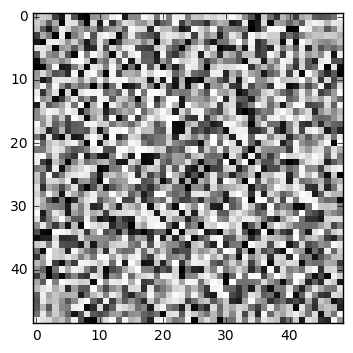

In [14]:
## we can also calculate something slightly more complicated,
## we'll make a fake correlation matrix from scratch, look for
## networks using clustering analysis, and then calculate the 
## participation coefficient of a given node

# generate random connectivity matrix
gen_mtx = np.random.random((49,49))

# now make its symettrical like a real connectivity matrix
diag = gen_mtx.diagonal()
lo_tri = np.tril(gen_mtx)
up_tri = lo_tri.transpose()
mtx = lo_tri + up_tri
for i in range(49):
    mtx[i][i] = diag[i]
    
print('here is our matrix \n',mtx)
print('\n and here is what it looks like visualized')
pyplot.imshow(mtx,
              cmap="Greys",
              interpolation="none")
pyplot.show()
    




now here's the new matrix!


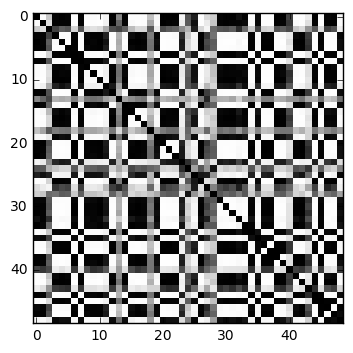

In [15]:
# and lets make use partial correlations to make it slightly more sparse
def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

pc_mtx = partial_corr(mtx)

print('now here\'s the new matrix!')
pyplot.imshow(pc_mtx,
              cmap="Greys",
              interpolation="none")
pyplot.show()
        


and here is our matrix reordered by cluster membership


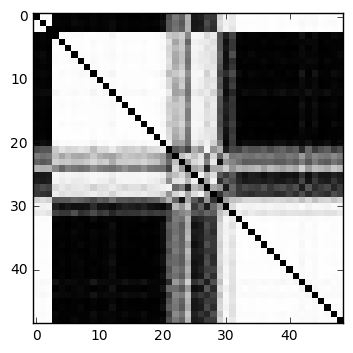

wow, doesn't it look like there is something real happening here?


In [16]:
# Let's make some sense out of this nonsense. We'll run clustering
# analysis on our random connectivity matrix

from sklearn.cluster import KMeans
# run clustering analysis and get labels
kmeans = KMeans(n_clusters=7, random_state=0).fit(pc_mtx)
labz = kmeans.labels_.tolist()
# reorder connectivity matrix by cluster labels
naxis = []
for x in range(7):
    for i in range(49):
        if labz[i] == x:
            naxis.append(i)
npc_mtx = pc_mtx[:, naxis][naxis]

print('and here is our matrix reordered by cluster membership')
pyplot.imshow(npc_mtx,
              cmap="Greys",
              interpolation="none")
pyplot.show()
print('wow, doesn\'t it look like there is something real happening here?')

In [20]:
MAYBE TAKE THIS PART OUT

## now lets calculate the participation coefficient of a node
## you can do this with less lines using specialized functions
## in pythons, but I want to show you that you can do it from
## scratch as well. Because PYTHON !!!!!!!!!!!!

def part_coef(mtrx,node,clust_labels):
    con_strength = np.sum(mtrx[node])
    to_sum = []
    for s in range(len(set(labz))):
        net_cons = []
        for i in range(49):
            if labz[i] == s:
                net_cons.append(mtrx[node][i])
        net_coef = (np.mean(net_cons) / con_strength)**2
        to_sum.append(net_coef)
    print('the participation coefficeint for network %s is %s'%(node,np.sum(to_sum)))
    print('the participation coefficeint for network %s is %s'%(node,np.mean(to_sum)))

part_coef(pc_mtx,5,labz)

the participation coefficeint for network 5 is 1.12892012045
the participation coefficeint for network 5 is 0.161274302921


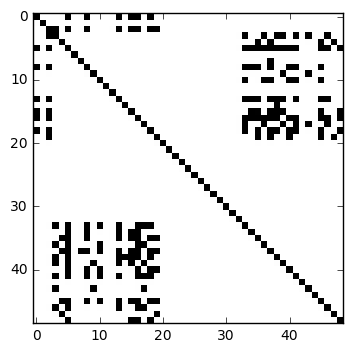

not very pretty


{0: 0.026737618026206136,
 1: 0.008858897287539727,
 2: 0.0,
 3: 0.0,
 4: 0.016477696537540124,
 5: 0.00228840830784697,
 6: 0.05354398768450807,
 7: 0.017083606801554675,
 8: 0.0,
 9: 0.0,
 10: 0.012942836361556583,
 11: 0.0,
 12: 0.0033876867748616046,
 13: 0.0,
 14: 0.006845246998732017,
 15: 0.0010491987822564474,
 16: 0.007203288253579522,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.04692467862746405,
 21: 0.030730537787154857,
 22: 0.02826431394528344,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.03101825108216131,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.006974037977444221,
 31: 0.016477696537540124,
 32: 0.0,
 33: 0.0037088488498454083,
 34: 0.0,
 35: 0.0,
 36: 0.021742826054793732,
 37: 0.039031855713820764,
 38: 0.022101983592003036,
 39: 0.005923275423552603,
 40: 0.0,
 41: 0.011994173670168532,
 42: 0.02005729759667002,
 43: 0.0,
 44: 0.018167897377487918,
 45: 0.018479343954824277,
 46: 0.0003256591097040414,
 47: 0.0012687799619140055,
 48: 0.0}

In [27]:
## of course, we don't have to do this manually. There are
## specialized python functions that do the dirty work for you

## first lets convert this to a binarized matrix where we save
## only the top 10% of connections

flat = np.tril(pc_mtx).flatten()
flat = [abs(x) for x in flat]
top_no = int(len(flat) * 0.90)
top_10 = sorted(flat)[top_no]
bin_mtx = np.full((49,49),np.nan)
for i in range(49):
    for j in range(49):
        if pc_mtx[i][j] > top_10:
            bin_mtx[i][j] = 1
        else:
            bin_mtx[i][j] = 0
nbin_mtx = bin_mtx[:, naxis][naxis]
pyplot.imshow(nbin_mtx,
              cmap="Greys",
              interpolation="none")
pyplot.show()
print('not very pretty')

# but assuming we had a real matrix it would look better
# Lets run some graph metrix. Choose your poison

G = nx.from_numpy_matrix(bin_mtx)
nx.betweenness_centrality(G)


In [243]:
## we can also run more traditional statistics like correlations
## lets generate some fake data and run a correlation

7.0